# Analyzing Boston's Rideshare Data

In [ ]:
# General imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import copy
from pingouin import ttest


# Data pipeline imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## Load Data Set

In [ ]:
df = pd.read_excel('rideshare.xls')
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


## EDA

In [ ]:
# Get shape of the data set
df.shape

(11999, 57)

In [ ]:
# Get number of null values
df.isnull().sum()

id                               0
timestamp                        0
hour                             0
day                              0
month                            0
datetime                         0
timezone                         0
source                           0
destination                      0
cab_type                         0
product_id                       0
name                             0
price                          931
distance                         0
surge_multiplier                 0
latitude                         0
longitude                        0
temperature                      0
apparentTemperature              0
short_summary                    0
long_summary                     0
precipIntensity                  0
precipProbability                0
humidity                         0
windSpeed                        0
windGust                         0
windGustTime                     0
visibility                       0
temperatureHigh     

In [ ]:
# Number of unique values in each data set
df.nunique()

id                             11999
timestamp                      10878
hour                              24
day                               17
month                              2
datetime                        9253
timezone                           1
source                            12
destination                       12
cab_type                           2
product_id                        13
name                              13
price                            101
distance                         360
surge_multiplier                   6
latitude                          11
longitude                         12
temperature                      308
apparentTemperature              319
short_summary                      9
long_summary                      11
precipIntensity                   63
precipProbability                 29
humidity                          51
windSpeed                        291
windGust                         286
windGustTime                      25
v

## Preprocessing Pipeline

In [ ]:
# Define drop columns
drop = ['id', 'timezone', 'timestamp', 'latitude', 'longitude', 'product_id',
        'uvIndexTime', 'short_summary', 'visibility.1', 'icon', 'datetime']

# Add all columns with Time measurements -> we only need one time measurement
for cols in df.columns:
    if "Time" in cols:
        drop.append(cols)

In [ ]:
# Drop columns
df = df.drop(drop,axis=1)
df = df.dropna()

In [ ]:
df.head()

,hour,day,month,source,destination,cab_type,name,price,distance,surge_multiplier,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
0,9,16,12,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,1.0,...,57,0.72,0,303.8,0.30,0.1276,39.89,43.68,33.73,38.07
1,2,27,11,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,1.0,...,90,1.00,0,291.1,0.64,0.1300,40.49,47.30,36.20,43.92
2,1,28,11,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,1.0,...,240,0.03,0,315.7,0.68,0.1064,35.36,47.55,31.04,44.12
3,4,30,11,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,1.0,...,310,0.00,0,291.1,0.75,0.0000,34.67,45.03,30.30,38.53
4,3,29,11,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,1.0,...,303,0.44,0,347.7,0.72,0.0001,33.10,42.18,29.11,35.75


In [ ]:
# General one-hot encoding for both dfs
df = pd.get_dummies(df, columns=['source', 'destination'])

In [ ]:
df.head()

,hour,day,month,cab_type,name,price,distance,surge_multiplier,temperature,apparentTemperature,...,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End
0,9,16,12,Lyft,Shared,5.0,0.44,1.0,42.34,37.12,...,0,0,0,0,0,1,0,0,0,0
1,2,27,11,Lyft,Lux,11.0,0.44,1.0,43.58,37.35,...,0,0,0,0,0,1,0,0,0,0
2,1,28,11,Lyft,Lyft,7.0,0.44,1.0,38.33,32.93,...,0,0,0,0,0,1,0,0,0,0
3,4,30,11,Lyft,Lux Black XL,26.0,0.44,1.0,34.38,29.63,...,0,0,0,0,0,1,0,0,0,0
4,3,29,11,Lyft,Lyft XL,9.0,0.44,1.0,37.44,30.88,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df_uber = df[df['cab_type'] == "Uber"]
df_lyft = df[df['cab_type'] == "Lyft"]

In [ ]:
df_uber= df_uber.drop(['cab_type'], axis=1)
df_lyft= df_lyft.drop(['cab_type'], axis=1)

In [ ]:
df_uber.columns

Index(['hour', 'day', 'month', 'name', 'price', 'distance', 'surge_multiplier',
       'temperature', 'apparentTemperature', 'long_summary', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust', 'visibility',
       'temperatureHigh', 'temperatureLow', 'apparentTemperatureHigh',
       'apparentTemperatureLow', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'moonPhase', 'precipIntensityMax',
       'temperatureMin', 'temperatureMax', 'apparentTemperatureMin',
       'apparentTemperatureMax', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenw

In [ ]:
# Encode Uber and Lyftcar types
df_uber = pd.get_dummies(df_uber, columns = ['name'])
df_lyft = pd.get_dummies(df_lyft, columns = ['name'])

## Data Visualization

### Distribution of Prices Across Rideshare Companies

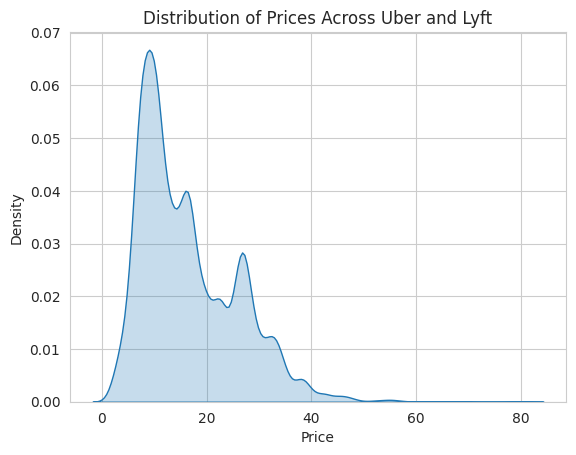

In [ ]:
# Plot distribution plot
sns.set_style('whitegrid')  # Set the grid style
sns.kdeplot(df['price'], fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Prices Across Uber and Lyft');

### Distribution of Prices Against Major Weather Patterns

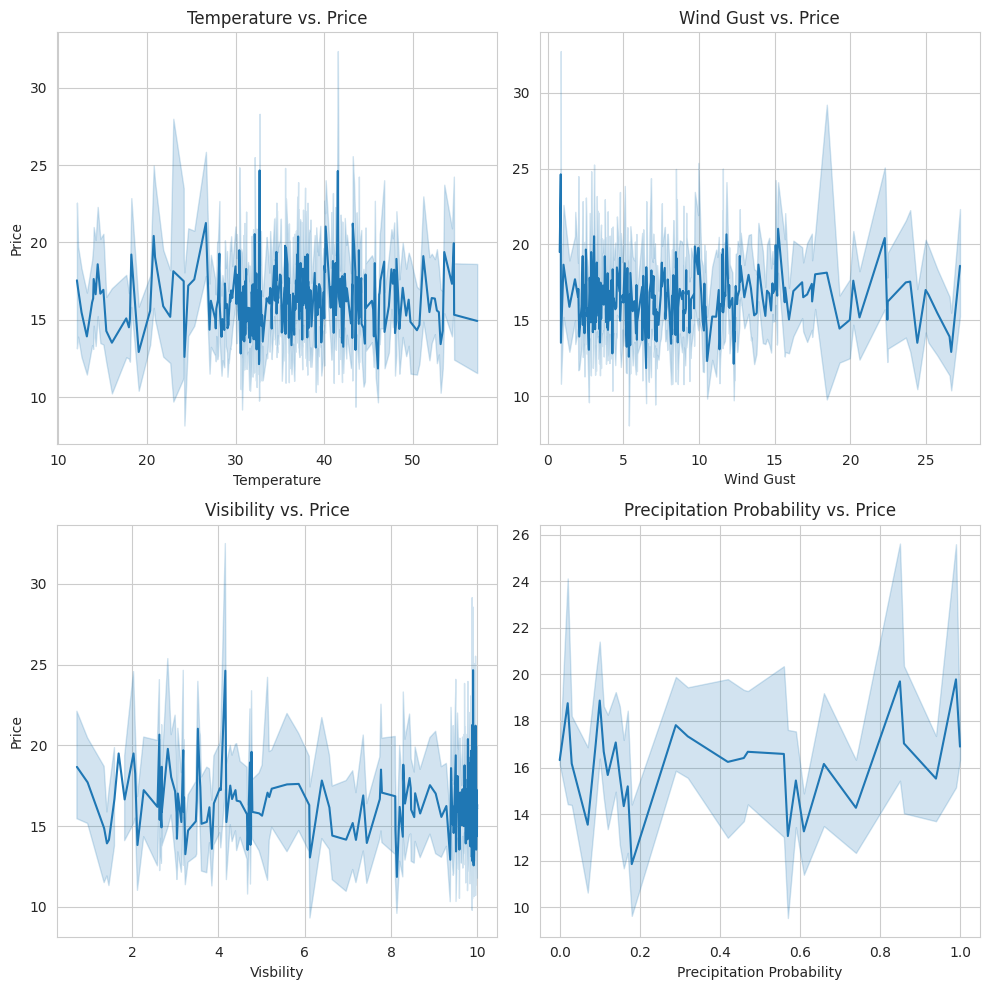

In [ ]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.set_style('ticks')  # Set the grid style


# Set up lineplots for each variable
sns.lineplot(data=df, x='apparentTemperature', y='price', ax=axes[0, 0])
sns.lineplot(data=df, x='windGust', y='price', ax=axes[0, 1])
sns.lineplot(data=df, x='visibility', y='price', ax=axes[1, 0])
sns.lineplot(data=df, x='precipProbability', y='price', ax=axes[1, 1])

# Set titles and labels
axes[0, 0].set_title('Temperature vs. Price')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Price')

axes[0, 1].set_title('Wind Gust vs. Price')
axes[0, 1].set_xlabel('Wind Gust')
axes[0, 1].set_ylabel('')

axes[1, 0].set_title('Visibility vs. Price')
axes[1, 0].set_xlabel('Visbility')
axes[1, 0].set_ylabel('Price')

axes[1, 1].set_title('Precipitation Probability vs. Price')
axes[1, 1].set_xlabel('Precipitation Probability')
axes[1, 1].set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Distribution of Prices Against Distance

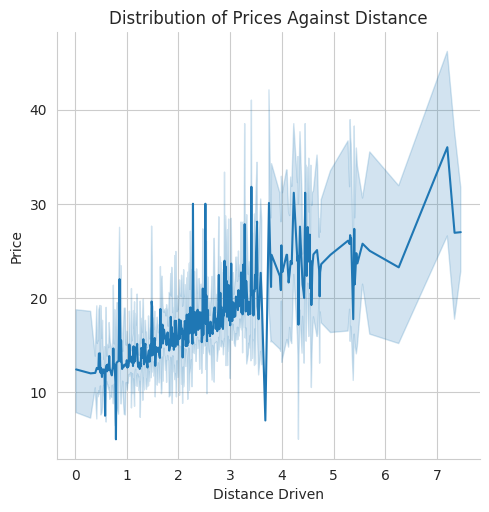

In [ ]:
# Create relation plot
sns.set_style('whitegrid')  # Set the grid style
sns.relplot(data=df, x='distance', y='price', kind="line")
plt.title('Distribution of Prices Against Distance')
plt.xlabel('Distance Driven')
plt.ylabel('Price');

### Distribution of Price Surges Against Time of Day

<ipython-input-58-1a78e0767ee0>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = pd.DataFrame(df.groupby(['hour']).mean())


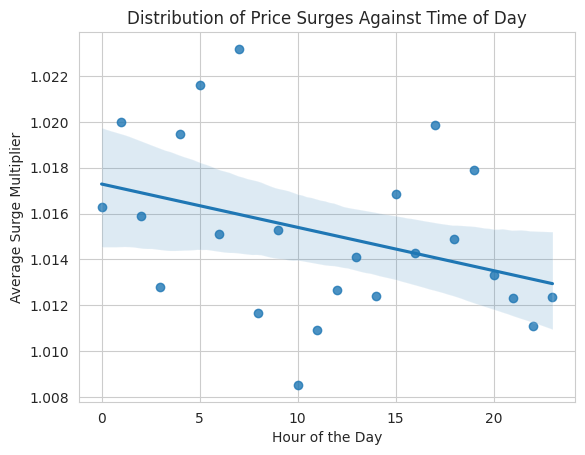

In [ ]:
sns.set_style('whitegrid')  # Set the grid style

# Group DF by Hour of Time
df_grouped = pd.DataFrame(df.groupby(['hour']).mean())

# Plot regression plot to see if there is a linear relationship
sns.regplot(x=df_grouped.index, y=df_grouped['surge_multiplier'])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Surge Multiplier')
plt.title('Distribution of Price Surges Against Time of Day');

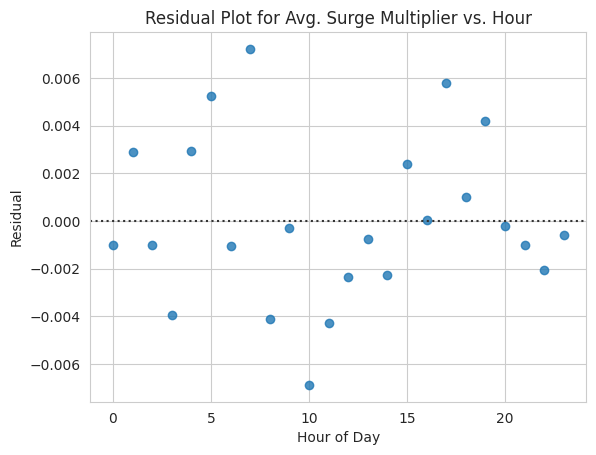

In [ ]:
# Plot residual plot to see if linear relationship is a good fit
sns.set_style('whitegrid')  # Set the grid style
sns.residplot(x=df_grouped.index, y=df_grouped['surge_multiplier'])
plt.xlabel('Hour of Day')
plt.ylabel('Residual')
plt.title('Residual Plot for Avg. Surge Multiplier vs. Hour');

<strong>Analysis: </strong>There is no apparent relationship in the distribution of residuals for the linear plot described above. Hence, the linear relationship is somewhat representative of the relationship between the average surge multiplier and the hour of day. However, there is no obvious indication of a negative relationship between the two variables as the regression plot clearly doesn't represent the data shown.

# ML Implementation

### Overview

I'd like to take the various inputs using various Regression models to try and predict the price of an Uber and Lyft. Using the same variables, I'd like to create seperate regression models for these two rideshare companies to analyze how their pricing model works. Then, post-training the regression models for each of the individual rideshare companies, I'd like to test how the model predicts prices for the same data but for the other rideshare company. With reasonable accuracy, if both models predict vastly different prices for the respective rideshare companies, we know that the specific rideshare company with higher-than-predicted pricing is pricing unfairly.

### Regression Model for Uber

In [ ]:
# Extract features and target variables for both data frames
x_feat_uber = [col for col in df_uber.columns if col not in ['price', 'long_summary']]
y_feat_uber = 'price'

x_uber = df_uber.loc[:, x_feat_uber].values
y_uber = df_uber.loc[:, y_feat_uber].values

In [ ]:
# Split datasets into test and train values
XU_train, XU_test, yU_train, yU_test = train_test_split(x_uber, y_uber, test_size=0.33, random_state=42)

In [ ]:
# Create the regression model and fit the training data in it
reg_uber = LinearRegression().fit(XU_train, yU_train)

In [ ]:
# Predict on the test data
pred = reg_uber.predict(XU_test)

In [ ]:
# Create a df with predicted and actual outputs for Uber
uber_reg_df = pd.DataFrame(list(zip(XU_test.ravel(), yU_test.ravel(), pred.ravel())),
               columns =['X', 'Actual Y', 'Predicted Y'])

In [ ]:
# Explore correlations in resultant data set
uber_reg_df.corr()

,X,Actual Y,Predicted Y
X,1.000000,0.003141,0.007011
Actual Y,0.003141,1.000000,0.960364
Predicted Y,0.007011,0.960364,1.000000


In [ ]:
# Score regression model
reg_uber.score(X=XU_test, y=yU_test)

0.9222544900376693

### Regression Model for Lyft

In [ ]:
# Define target and features and extract values
x_feat_lyft = [col for col in df_lyft.columns if col not in ['price', 'long_summary']]
y_feat_lyft = 'price'

x_lyft = df_lyft.loc[:, x_feat_lyft].values
y_lyft = df_lyft.loc[:, y_feat_lyft].values

In [ ]:
# Split into train and test data
XL_train, XL_test, yL_train, yL_test = train_test_split(x_lyft, y_lyft, test_size=0.33, random_state=42)

In [ ]:
# Create the regression model and fit the training data in it
reg_lyft = LinearRegression().fit(XL_train, yL_train)

In [ ]:
# Predict on the test data
pred = reg_lyft.predict(XL_test)

In [ ]:
# Create a df with predicted and actual outputs for Uber
lyft_reg_df = pd.DataFrame(list(zip(XL_test.ravel(), yL_test.ravel(), pred.ravel())),
               columns =['X', 'Actual Y', 'Predicted Y'])

In [ ]:
# Explore correlations in resultant data set
lyft_reg_df.corr()

,X,Actual Y,Predicted Y
X,1.000000,0.007187,0.018441
Actual Y,0.007187,1.000000,0.968601
Predicted Y,0.018441,0.968601,1.000000


In [ ]:
# Score regression model
reg_lyft.score(X=XL_test, y=yL_test)

0.9376103274052396

### Model Analysis:

In [ ]:
# Define feature importance plot function
def plot_feat_import(feat_list, feat_import, x_label, y_label, title, sort=True, limit=None):
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx]

    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]

    sns.set_style('darkgrid')
    # plot and label feature importance
    sns.barplot(x=feat_list, y=feat_import)
    plt.gcf().set_size_inches(10, len(feat_list) / 2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90)

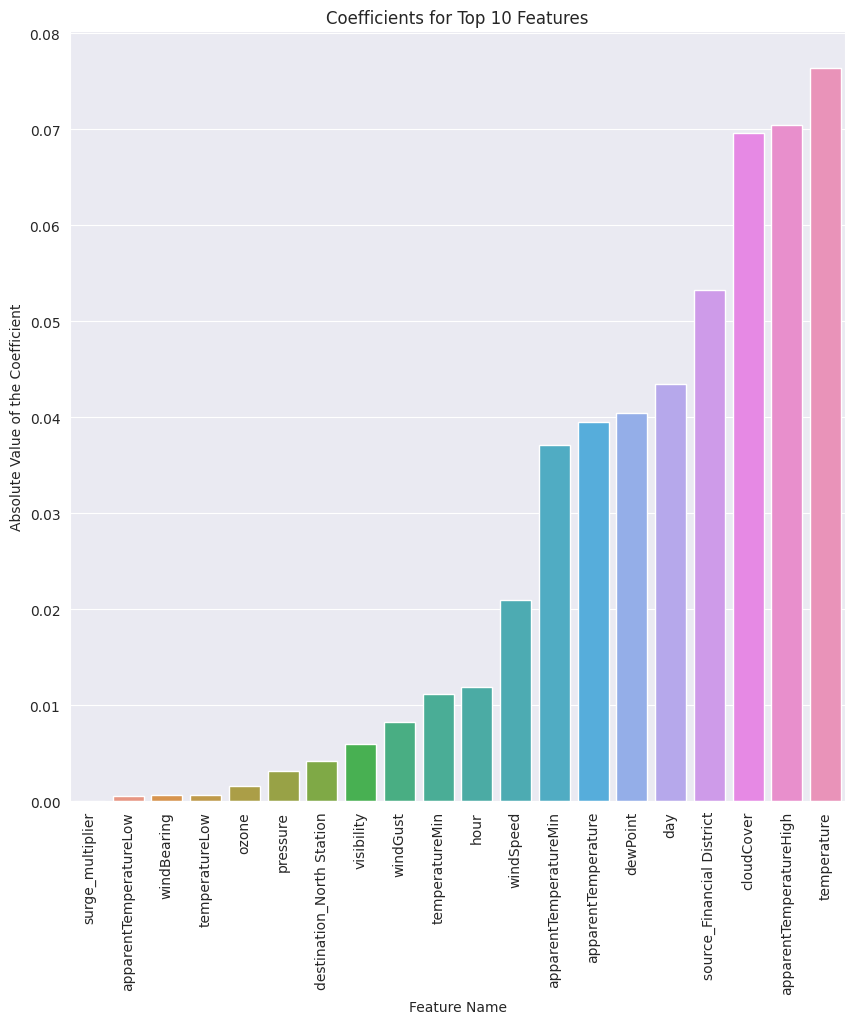

In [ ]:
# Set up the figure and axes
sns.set_style('ticks')  # Set the grid style
plot_feat_import(feat_list=x_feat_uber, feat_import=np.abs(reg_uber.coef_),
                 title='Coefficients for Top 20 Features',
                 x_label='Feature Name',
                 y_label='Absolute Value of the Coefficient',limit=20)


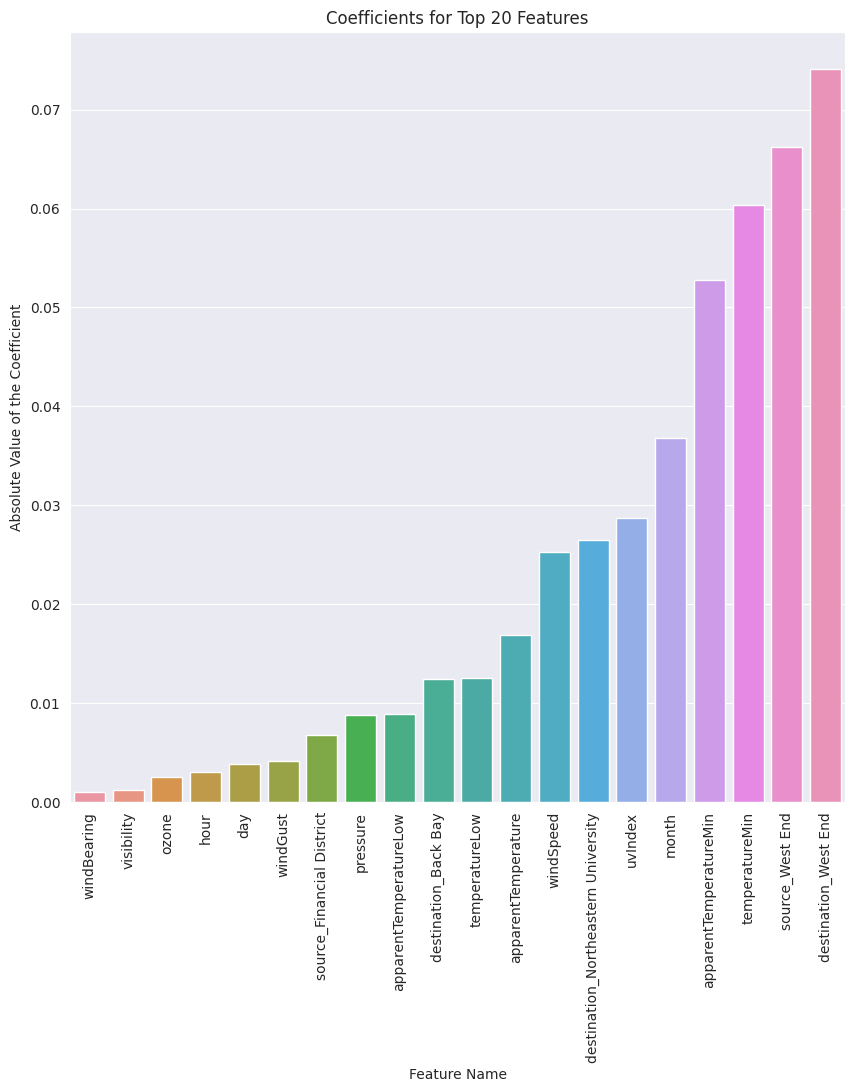

In [ ]:
plot_feat_import(feat_list=x_feat_lyft, feat_import=np.abs(reg_lyft.coef_),
                 title='Coefficients for Top 20 Features',
                 x_label='Feature Name',
                 y_label='Absolute Value of the Coefficient',limit=20)

The regression model to predict Uber prices has a r-value of 0.92225, which indicates that the pricing of Uber rides are very linearly correlated and carry a very strong positive correlation. With the above features, we can tell by the absolute value of the coefficients that Uber's pricing model relies more on enviormental factors such as temperature, day of the week, dew point, etc.

Similarly, the regression model to predict Lyft prices has a r-value of 0.9376, which indicates that the pricing of Lyft rides are very linearly correlated and carry a very strong positive correlation. With the above features, we can tell by the absolute value of the coefficients that Lyft's pricing model is reliant more on locality. The pricing model suggests that (generalizing to the Boston area) Lyft more significantly weights pricing on ride share destinations.

## Cross-Analysis

### Introduction

The goal in this segment is to cross-analyze whether or not Uber and/or Lyft overcharges for their rides. From the data analysis section, we can see that Uber and Lyft have similar pricing overall when aggregated across all rides in the data set. To test if both rideshare companies truly price fairly, my goal is to cross-verify Lyft rideshare data in the regression model created for Uber and see if it returns similar prices and vice versa. <br>

If both companies price fairly, the models should return similar predicted prices. Else, we can generalize that the specific rideshare company in question is pricing unfairly. To further analyze this, I will conduct statistical tests on both datasets to generalize price differences to the Boston area for rideshare companies.

### Analyze Uber Rideshare Data in Lyft Model

In [ ]:
# Use Uber data into Lyft model
pred = reg_lyft.predict(x_uber[:x_lyft.shape[0]])

In [ ]:
# Create crosstab dataframe with the same shape as the lyft data
crosstab_lyft = copy(df_lyft[:x_lyft.shape[0]])

In [ ]:
# Store predictions in the crosstab dataframe
crosstab_lyft['uber_price_pred'] = pred

In [ ]:
# Display aggregate data
crosstab_lyft.tail()

,hour,day,month,price,distance,surge_multiplier,temperature,apparentTemperature,long_summary,precipIntensity,...,destination_South Station,destination_Theatre District,destination_West End,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,uber_price_pred
11992,10,14,12,7.0,2.75,1.0,27.71,27.71,Partly cloudy throughout the day.,0.0000,...,0,1,0,0,0,0,0,0,1,4.845294
11993,23,29,11,30.0,2.75,1.0,40.29,34.73,Partly cloudy throughout the day.,0.0000,...,0,1,0,0,0,1,0,0,0,8.077009
11994,14,26,11,9.0,2.75,1.0,43.51,43.51,"Rain until morning, starting again in the eve...",0.0053,...,0,1,0,0,0,0,1,0,0,28.393013
11995,6,2,12,16.5,2.75,1.0,37.96,37.96,Light rain until evening.,0.0000,...,0,1,0,1,0,0,0,0,0,18.816950
11996,16,17,12,16.5,2.75,1.0,37.62,32.77,Light rain in the morning.,0.0000,...,0,1,0,0,0,0,0,1,0,2.870521


### Analyze Lyft Rideshare Data in Uber Model

In [ ]:
# Use Lyft data into Uber model
pred = reg_uber.predict(x_lyft)

In [ ]:
# Create crosstab dataframe with the same shape as the uber data
crosstab_uber = copy(df_uber[:pred.shape[0]])

In [ ]:
# Store predictions in the crosstab dataframe
crosstab_uber['lyft_price_pred'] = pred

In [ ]:
# Display aggregate data
crosstab_uber.tail()

,hour,day,month,price,distance,surge_multiplier,temperature,apparentTemperature,long_summary,precipIntensity,...,destination_South Station,destination_Theatre District,destination_West End,name_Black,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV,lyft_price_pred
11631,23,28,11,9.5,1.61,1.0,39.35,33.00,Mostly cloudy throughout the day.,0.0000,...,0,0,0,0,0,0,0,0,1,10.975108
11632,2,16,12,9.5,1.61,1.0,40.87,37.73,Mostly cloudy throughout the day.,0.0000,...,0,0,0,0,0,0,1,0,0,9.910018
11639,14,17,12,7.5,1.41,1.0,36.45,31.00,Light rain in the morning.,0.0005,...,0,0,0,0,0,1,0,0,0,11.023847
11640,17,3,12,26.5,1.41,1.0,54.59,54.59,Foggy in the morning.,0.0000,...,0,0,0,0,1,0,0,0,0,21.849377
11641,21,28,11,8.0,1.41,1.0,41.35,35.62,Mostly cloudy throughout the day.,0.0000,...,0,0,0,0,0,0,0,0,1,16.773438


#### Visualize Results

In [ ]:
crosstab_lyft['uber_price_pred'].describe()

count    5454.000000
mean       16.760163
std         9.230618
min        -0.640222
25%         9.829760
50%        15.797289
75%        23.247664
max        49.568897
Name: uber_price_pred, dtype: float64

In [ ]:
crosstab_uber['lyft_price_pred'].describe()

count    5454.000000
mean       15.539342
std         8.116306
min         3.344564
25%         9.023252
50%        12.992275
75%        20.378962
max        39.024965
Name: lyft_price_pred, dtype: float64

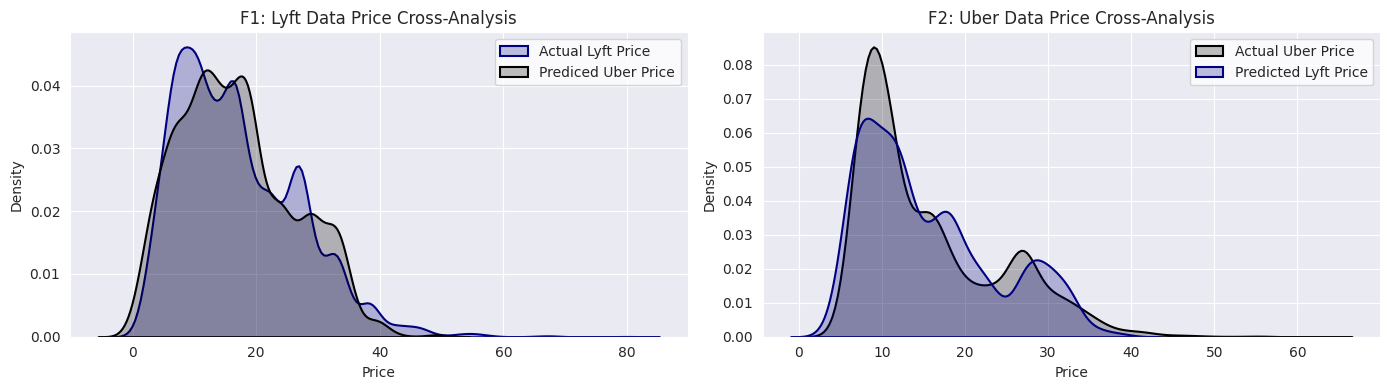

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.set_style('ticks')  # Set the grid style


# Add Lyft actual prices compared to predicted prices for Uber in plot 1
sns.kdeplot(crosstab_lyft, x='price', fill=True, ax=axes[0], color='navy', label='Actual Lyft Price', linewidth=1.5)
sns.kdeplot(crosstab_lyft, x='uber_price_pred', fill=True, ax=axes[0], color='black', label='Prediced Uber Price', linewidth=1.5)
axes[0].set_title('F1: Lyft Data Price Cross-Analysis')
axes[0].set_xlabel('Price')

# Set the legend
axes[0].legend()

# Add Uber actual prices compared to predicted prices for Lyft in plot 2
sns.kdeplot(crosstab_uber, x='price', fill=True, ax=axes[1], color='black', label='Actual Uber Price', linewidth=1.5)
sns.kdeplot(crosstab_uber, x='lyft_price_pred', fill=True, ax=axes[1], color='navy',label='Predicted Lyft Price', linewidth=1.5)
axes[1].set_title('F2: Uber Data Price Cross-Analysis')
axes[1].set_xlabel('Price')

# Set the legend
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

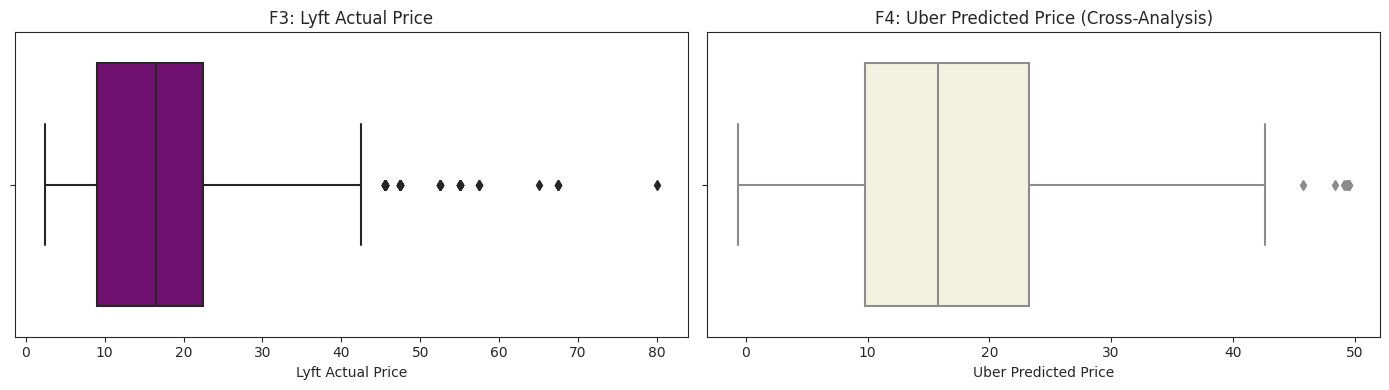

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.set_style('ticks')  # Set the grid style

# Add Lyft actual prices compared to predicted prices for Uber in plot 1
sns.boxplot(crosstab_lyft, x='price', ax=axes[0], color='purple')
sns.boxplot(crosstab_lyft, x='uber_price_pred', ax=axes[1], color='beige')
axes[0].set_title('F3: Lyft Actual Price')
axes[1].set_title('F4: Uber Predicted Price (Cross-Analysis)')
axes[0].set_xlabel('Lyft Actual Price')
axes[1].set_xlabel('Uber Predicted Price')

# Show the plot
plt.tight_layout()
plt.show()

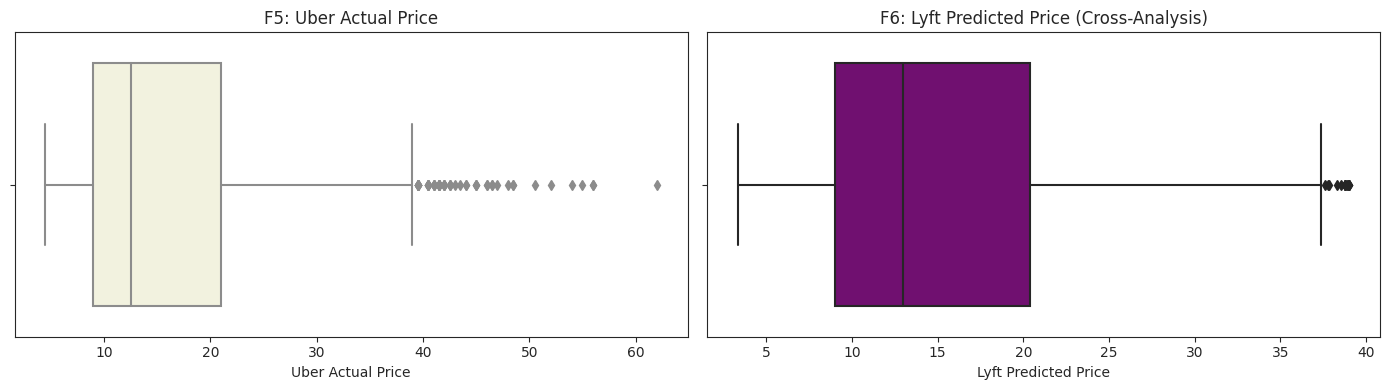

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.set_style('ticks')  # Set the grid style

# Add Lyft actual prices compared to predicted prices for Uber in plot 1
sns.boxplot(crosstab_uber, x='price', ax=axes[0], color='beige')
sns.boxplot(crosstab_uber, x='lyft_price_pred', ax=axes[1], color='purple')
axes[0].set_title('F5: Uber Actual Price')
axes[1].set_title('F6: Lyft Predicted Price (Cross-Analysis)')
axes[0].set_xlabel('Uber Actual Price')
axes[1].set_xlabel('Lyft Predicted Price')

# Show the plot
plt.tight_layout()
plt.show()

### Cross-Analysis Results

Through this analysis, it is indeterminant whether or not Lyft or Uber charges more than the other. We can only generalize the results to the current data set about Boston Rideshare and cannot statisically generalize to the entire population. In Figure F1, the KDE plot shows us that Lyft has a higher probability of charging lower prices than Uber's predicted probability for the same rides. In contrast, figure F2's KDE plot shows that Lyft is less likely to charge lower prices compared to Uber for the same rides. In conclusion, we cannot conclusively tell if either rideshare company charges more than the other for the same rides. <br>

In order to 1) generalize the results to the entire Boston area and 2) determine if there is conclusive evidence that either rideshare company charges higher than the other, we must perform statistical hypothesis testing.

## Hypothesis Testing

### Introduction

As mentioned previously, since cross-analysis of the rideshare data for Uber and Lyft do not show conclusive evidence of price differences, hypothesis testing will help conclude whether or not their is a significant difference in prices charged by Lyft and Uber.

In this section, I will perform a two-tailed hypothesis test against the mean prices charged for both rideshare companies. The objective is to test if there is a significant enough difference between the prices charged between the two companies.

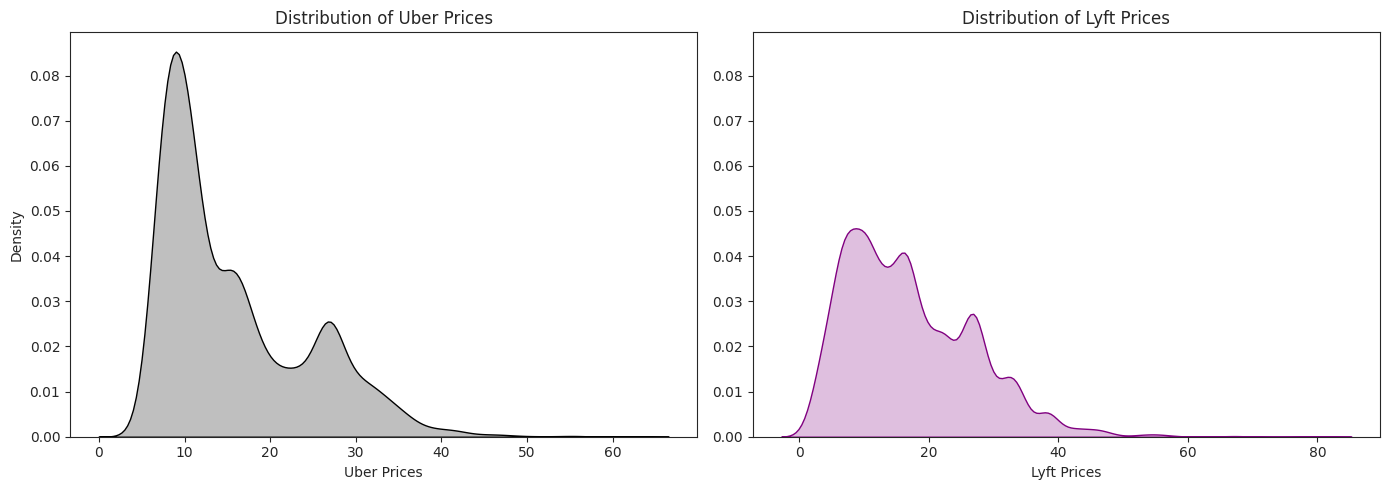

In [ ]:
# Check if Uber and Lyft price distributions are approximately normal
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style('whitegrid')  # Set the grid style

# Plot the distribution for Uber
sns.kdeplot(df_uber['price'], ax=axes[0], fill=True, color='black')

# Plot the distribution for Lyft
sns.kdeplot(df_lyft['price'], ax=axes[1], fill=True, color='purple')

# Set the same y-value limit for both plots
max_y = max(max(axes[0].get_ylim()), max(axes[1].get_ylim()))
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)

# Set titles and labels
axes[0].set_title('Distribution of Uber Prices')
axes[0].set_xlabel('Uber Prices')
axes[0].set_ylabel('Density')

axes[1].set_title('Distribution of Lyft Prices')
axes[1].set_xlabel('Lyft Prices')
axes[1].set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Normality Assumptions:

From the above KDE plots, we can tell that both distribution of prices for both rideshare companies are heavily skewed, thus meaning that neither distribution is approximately normal. However, we can make a few statistical assumptions to obtain a normal sampling distribution:


With a sample size of *n_uber = 5614* and *n_lyft = 5454* and the population size of rideshares in Boston being *N_rideshare = ∞*, we can assume approximate normality for both distributions through the Central Limit Theorem under the following conditions:

1. *n_uber* < *N_rideshare* and *n_lyft* < *N_rideshare*
2. *n_uber* > 30 and *n_lyft* > 30



Assuming an approximately normal distribution for both Uber and Lyft rideshare data, we can define our null and alternate hypotheses as the following:

In [ ]:
H0: µ_uber_price >= µ_lyft_price # (population mean of dataset1 is equal to dataset2)

HA: µ_uber_price < µ_lyft_price # (population mean of dataset1 is different from dataset2)

### Two-Sided Welch T-Test

In [ ]:
# Check the variances of both uber and lyft price data
np.var(df_uber['price']), np.var(df_lyft['price'])

(72.243874733493, 95.71272915092513)

Since the sample variances are not equal, I will be using a **two-sided Welch T-test** (*Zimmerman 2004*)

In [ ]:
# Run T-test using Pingouin -> by default runs a two-tailed test
ttest(x=df_uber['price'], y=df_lyft['price'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.55247,10760.993985,two-sided,4.617013e-14,"[-1.66, -0.98]",0.143882,4.668e+10,1.0


### Analysis

From the above test, we recieved a *P-value* of 4.617013e-14, which is less than the significance level 0.05. Thus, we can reject the null hypothesis and conclude that there is a statistically significant difference between the prices charged by Uber and Lyft. However, the Cohen-D value of 0.143 is less than the minimum required value of 0.2 *(Cohen)*. Therefore, we can conclude that the difference is trivial, despite being stastically significant as per the two-tailed Welch T-Test.

In a larger context, rideshares have grown to be incredibly complex in how their pricing algorithms work. Though this dataset was extremely thorough in the features it captured, there are still many variables that were reasonably not captured. Hence, it is rather difficult to generalize the results to all rideshare rides across the US and across the world; we are only able to infer about the population of rideshares within the Boston area.